# ImageNet Feature Extraction
This experiment will involve feature extraction to predict image quality. Features will be extracted from varying levels of an Xception model, going from lower to higher layers. From these extracted features, a simple neural network will attempt to learn and predict image quality classes.

## Setup

In [1]:
!nvidia-smi

Sat Aug 31 09:43:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:86:00.0 Off |                    0 |
| N/A   33C    P0             44W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-08-31 09:43:54.493243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-31 09:43:54.514479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-31 09:43:54.521362: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-31 09:43:54.538041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-31 09:43:56.387824: W tensorflow/compiler/tf2

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [6]:
import numpy as np
import keras
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
# from torch.utils.data import DataLoader, Dataset

In [7]:
!pwd
!ls koa_scratch

/home/jctactay
images


## Data preprocessing

In [8]:
# load images
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img) / 127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict(img_dir):
    imgs = {}
    paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()
home = "/home/jctactay/koa_scratch/images"

imgs = load_images_into_dict(home)
print(f"Done in {time() - t0: .3f}s")

Done in  190.338s


In [9]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [10]:
print(len(imgs))

3613


In [11]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')

img_names = labels.image.tolist()
features = {k: v for k, v in imgs.items() if k in img_names}
assert len(features) == len(labels)

In [12]:
value_counts = labels.quality.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

quality
1    1116
2    1479
3     991
Name: count, dtype: int64

In [13]:
# check for nans
for k, v in zip(features.keys(), features.values()):
    if np.isnan(v.any()):
        print(k)

In [14]:
print(labels)

                 species                           image  distinctiveness  \
0        spinner_dolphin              0011f7a65044e4.jpg              2.0   
1        spinner_dolphin              007097146016e6.jpg              2.0   
2        spinner_dolphin              009a307f9f483c.jpg              2.0   
3        spinner_dolphin              00eea1a5b9d8bc.jpg              2.0   
4        spinner_dolphin              01287e826d29a8.jpg              2.0   
...                  ...                             ...              ...   
3587  melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg              2.0   
3588  melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg              1.0   
3589  melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg              NaN   
3590  melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg              1.0   
3591  melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg              1.0   

      quality  
0           3  
1           2  
2           1  
3          

In [15]:
Y = labels.quality
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([features[i] for i in labels.image])
print(len(Y))
print(len(X))

[0 1 2]
3586
3586


## Xception model

In [16]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False
base_model.summary(show_trainable=True)

2024-08-31 09:47:13.018327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer[0… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

## Helper functions

In [17]:
def plot_history(histories):
    num_subplots = len(histories[0].history.keys())//2 * len(histories)
    fig = plt.figure(figsize=(10,10))
    subfigs = fig.subfigures(num_subplots//2)
    for i, history in enumerate(histories):
        ax = subfigs[i].subplots(1, 2)
        f = 0
        subfigs[i].suptitle(f"Fold {i+1}")
        for metric in history.history.keys():
            ax[f].plot(history.history[metric], label=metric)
            ax[f].legend()
            f = int(not f)

In [18]:
def extract_train_predict(layer_name, callback=None, model=None):
    # inputs = keras.Input(shape=(128,128,3))
    extractor = keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    features = extractor.predict(X)
    print("Shape of features:", features.shape)
    X_train, X_test, Y_train, Y_test = train_test_split(features, Y, test_size=0.2, stratify=Y, random_state=42)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)
    classes = np.unique(Y_train)
    num_classes = len(classes)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
    print("Class weights:", class_weights)
    class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
    sample_weights = np.array([class_weights_dict[label] for label in Y_train])
    if model is None:
        model = keras.Sequential([
            tf.keras.Input(shape=X_train.shape[1:]),
            keras.layers.Flatten(),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation='softmax')
        ])
    print(model.summary())
    if callback is None:
        callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
    pred_soft = model.predict(X_test)
    preds = np.argmax(pred_soft, axis=1)
    report = classification_report(Y_test, preds)
    cm = confusion_matrix(Y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return history, report, disp

In [19]:
def build_model(model_arg=None, features=None, num_classes=3):
    if model_arg is None:
        model = keras.Sequential([
            tf.keras.Input(shape=features.shape[1:]),
            keras.layers.Flatten(),
            keras.layers.Dense(1024, activation='relu'),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation='softmax')
        ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [20]:
def extract_train_predict_cv(layer_name, callback_arg=None, model_arg=None):
    # inputs = keras.Input(shape=(128,128,3))
    extractor = keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
    features = extractor.predict(X)
    print("Shape of features:", features.shape)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    classes = np.unique(Y)
    num_classes = len(classes)
    fold_no = 1
    all_preds = np.zeros((X.shape[0], num_classes))
    histories = []
    for train_index, val_index in cv.split(X=features,y=Y):
        model = build_model(model_arg, features, num_classes)
        if callback_arg is None:
            callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)
        print(f'Training on fold {fold_no}...')
        X_train, X_val = features[train_index], features[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
        print("Class weights:", class_weights)
        class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
        sample_weights = np.array([class_weights_dict[label] for label in Y_train])
        history = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
        histories.append(history)
        pred_soft = model.predict(X_val)
        all_preds[val_index] = pred_soft
        fold_no += 1
    preds = np.argmax(all_preds, axis=1)
    report = classification_report(Y, preds)
    cm = confusion_matrix(Y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    return histories, report, disp

## block5_sepconv1_act

Testing intermediate layer

In [21]:
histories, report, disp = extract_train_predict_cv('block5_sepconv1_act')

I0000 00:00:1724892594.121438    8894 service.cc:146] XLA service 0x148270011750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724892594.121463    8894 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-08-29 00:49:54.132134: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 00:49:54.228350: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 31/113 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

I0000 00:00:1724892595.197299    8894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Shape of features: (3586, 8, 8, 728)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3685 - loss: 39.1861 - val_accuracy: 0.4652 - val_loss: 1.4334
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5118 - loss: 1.0449 - val_accuracy: 0.4763 - val_loss: 1.0032
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5563 - loss: 0.8339 - val_accuracy: 0.5655 - val_loss: 0.8656
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6444 - loss: 0.7745 - val_accuracy: 0.5446 - val_loss: 0.8853
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6134 - loss: 0.7508 - val_accuracy: 0.5696 - val_loss: 0.8627
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6786 - loss: 0.6915 - val_accuracy: 0.5864 - val_loss: 0.8725
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6408 - loss: 0.7165 - val_a

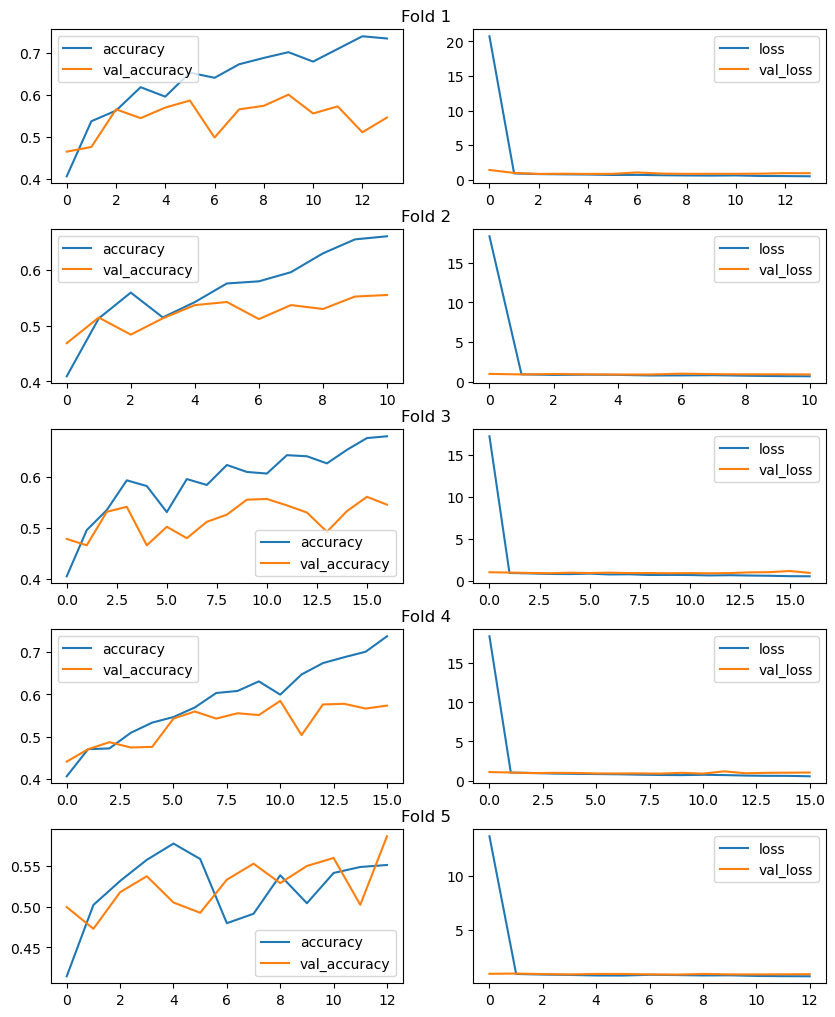

In [22]:
plot_history(histories)

In [23]:
print(report)

              precision    recall  f1-score   support

           0       0.59      0.60      0.60      1116
           1       0.52      0.45      0.49      1479
           2       0.57      0.68      0.62       991

    accuracy                           0.56      3586
   macro avg       0.56      0.58      0.57      3586
weighted avg       0.56      0.56      0.56      3586



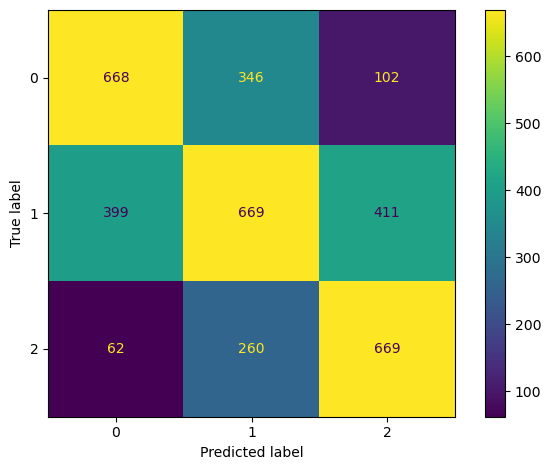

In [24]:
disp.plot()
plt.tight_layout()

## Layer 10 extraction (conv2d_3)

Layer 10 seemed to have the highest reported accuracy when fine-tuning.

In [25]:
print(base_model.layers[-10])

<Conv2D name=conv2d_3, built=True>


In [26]:
histories, report, disp = extract_train_predict_cv(base_model.layers[-10].name)

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Shape of features: (3586, 4, 4, 1024)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4290 - loss: 45.4051 - val_accuracy: 0.4958 - val_loss: 1.0323
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5042 - loss: 0.9687 - val_accuracy: 0.5237 - val_loss: 0.9163
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5378 - loss: 0.8860 - val_accuracy: 0.5125 - val_loss: 0.9303
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5188 - loss: 0.8966 - val_accuracy: 0.5487 - val_loss: 0.8989
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5491 - loss: 0.8549 - val_accuracy: 0.5418 - val_loss: 0.9102
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5497 - loss: 0.8706 - val_accuracy: 0.5042 - val_loss: 0.9228
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5495 - loss: 0.8551 - val_

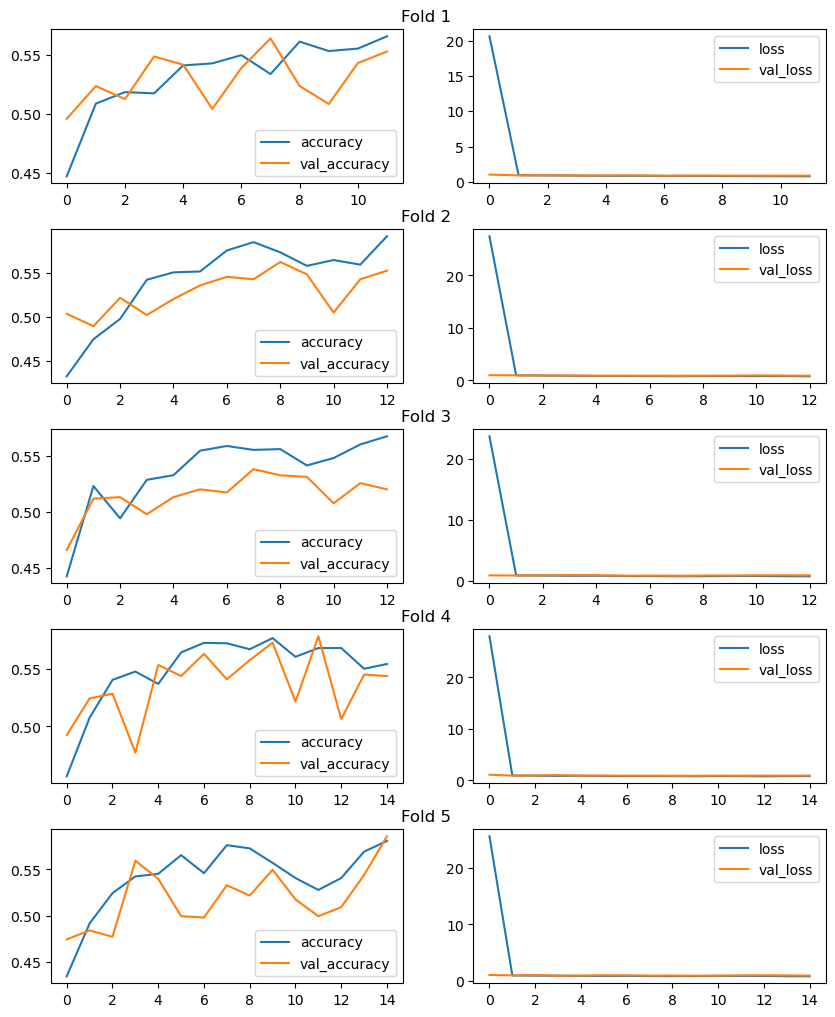

In [27]:
plot_history(histories)

In [28]:
print(report)

              precision    recall  f1-score   support

           0       0.52      0.75      0.62      1116
           1       0.55      0.31      0.40      1479
           2       0.58      0.68      0.63       991

    accuracy                           0.55      3586
   macro avg       0.55      0.58      0.55      3586
weighted avg       0.55      0.55      0.53      3586



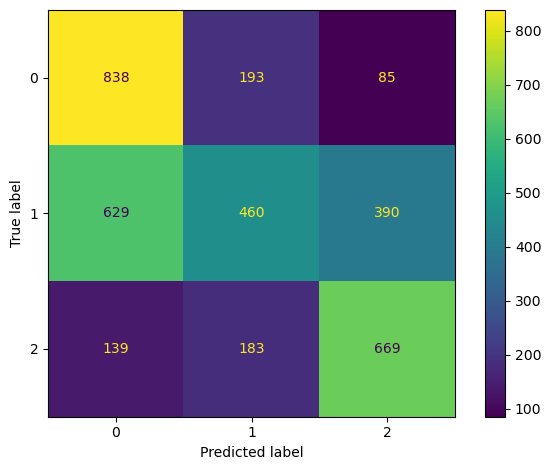

In [29]:
disp.plot()
plt.tight_layout()

## block4_sepconv2_act

In [30]:
histories, report, disp = extract_train_predict_cv('block4_sepconv2_act')

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Shape of features: (3586, 16, 16, 728)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.3688 - loss: 71.6368 - val_accuracy: 0.4582 - val_loss: 0.9906
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5402 - loss: 0.8716 - val_accuracy: 0.4833 - val_loss: 0.9526
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5731 - loss: 0.8149 - val_accuracy: 0.4889 - val_loss: 0.9367
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6360 - loss: 0.7355 - val_accuracy: 0.5669 - val_loss: 0.9106
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7140 - loss: 0.5765 - val_accuracy: 0.5474 - val_loss: 0.9768
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7298 - loss: 0.5607 - val_accuracy: 0.5571 - val_loss: 1.0209
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7768 - loss: 0.4743 

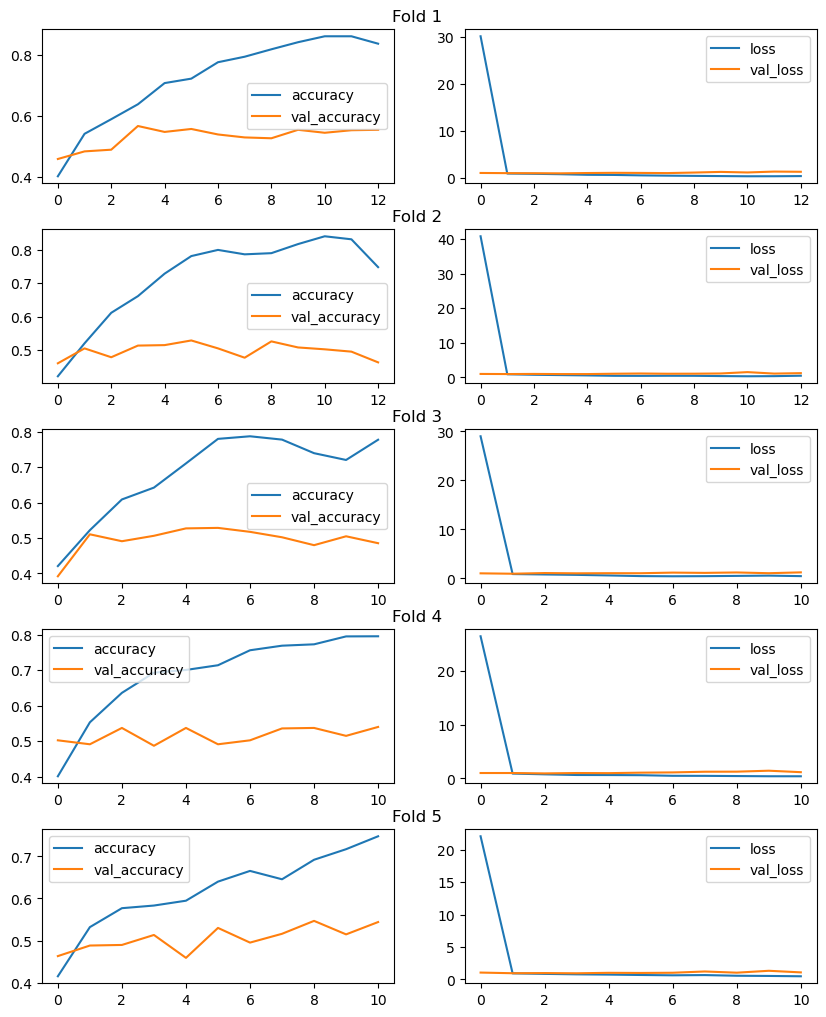

In [31]:
plot_history(histories)

In [32]:
print(report)

              precision    recall  f1-score   support

           0       0.51      0.57      0.54      1116
           1       0.48      0.45      0.46      1479
           2       0.57      0.54      0.55       991

    accuracy                           0.51      3586
   macro avg       0.52      0.52      0.52      3586
weighted avg       0.51      0.51      0.51      3586



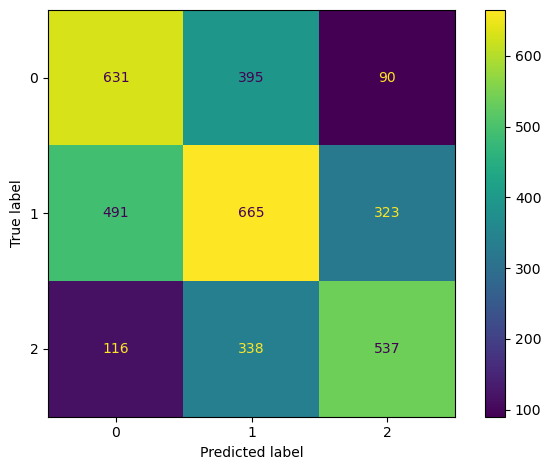

In [33]:
disp.plot()
plt.tight_layout()

## block6_sepconv1_act

In [34]:
histories, report, disp = extract_train_predict_cv('block6_sepconv1_act')

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Shape of features: (3586, 8, 8, 728)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3938 - loss: 50.2549 - val_accuracy: 0.5070 - val_loss: 0.9922
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5277 - loss: 0.9655 - val_accuracy: 0.5195 - val_loss: 0.9470
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5893 - loss: 0.8538 - val_accuracy: 0.5487 - val_loss: 0.9206
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5604 - loss: 0.8123 - val_accuracy: 0.5334 - val_loss: 0.9318
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5815 - loss: 0.7898 - val_accuracy: 0.5585 - val_loss: 0.8658
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6574 - loss: 0.7009 - val_accuracy: 0.5669 - val_loss: 0.8544
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6584 - loss: 0.6740 - val_a

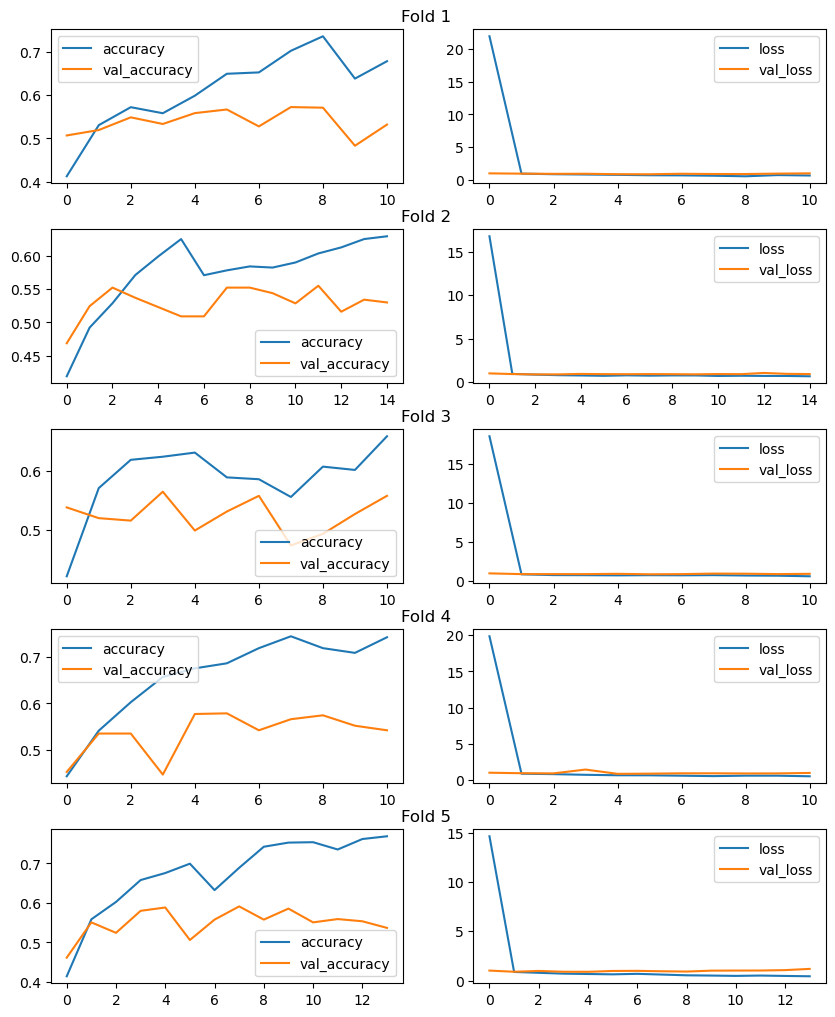

In [35]:
plot_history(histories)

In [36]:
print(report)

              precision    recall  f1-score   support

           0       0.55      0.68      0.61      1116
           1       0.53      0.37      0.44      1479
           2       0.59      0.69      0.64       991

    accuracy                           0.56      3586
   macro avg       0.56      0.58      0.56      3586
weighted avg       0.55      0.56      0.54      3586



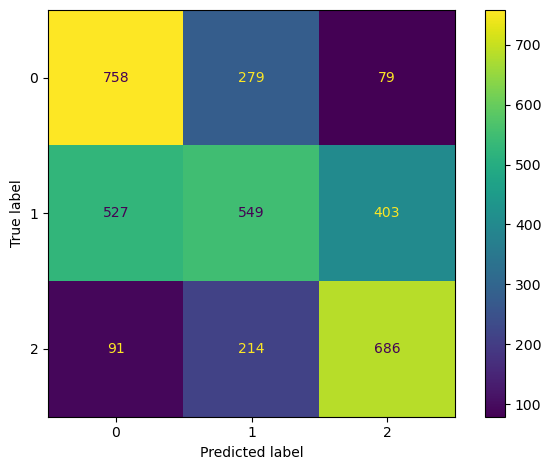

In [37]:
disp.plot()
plt.tight_layout()

## block5_sepconv2_act

In [38]:
histories, report, disp = extract_train_predict_cv('block5_sepconv2_act')

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Shape of features: (3586, 8, 8, 728)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4283 - loss: 8.6296 - val_accuracy: 0.5209 - val_loss: 0.9284
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6156 - loss: 0.7980 - val_accuracy: 0.5446 - val_loss: 0.8895
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7125 - loss: 0.6308 - val_accuracy: 0.5710 - val_loss: 0.8771
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7989 - loss: 0.4779 - val_accuracy: 0.5306 - val_loss: 1.1124
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8632 - loss: 0.3260 - val_accuracy: 0.5585 - val_loss: 1.0139
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9009 - loss: 0.2722 - val_accuracy: 0.5850 - val_loss: 1.1085
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9287 - loss: 0.1880 - val_ac

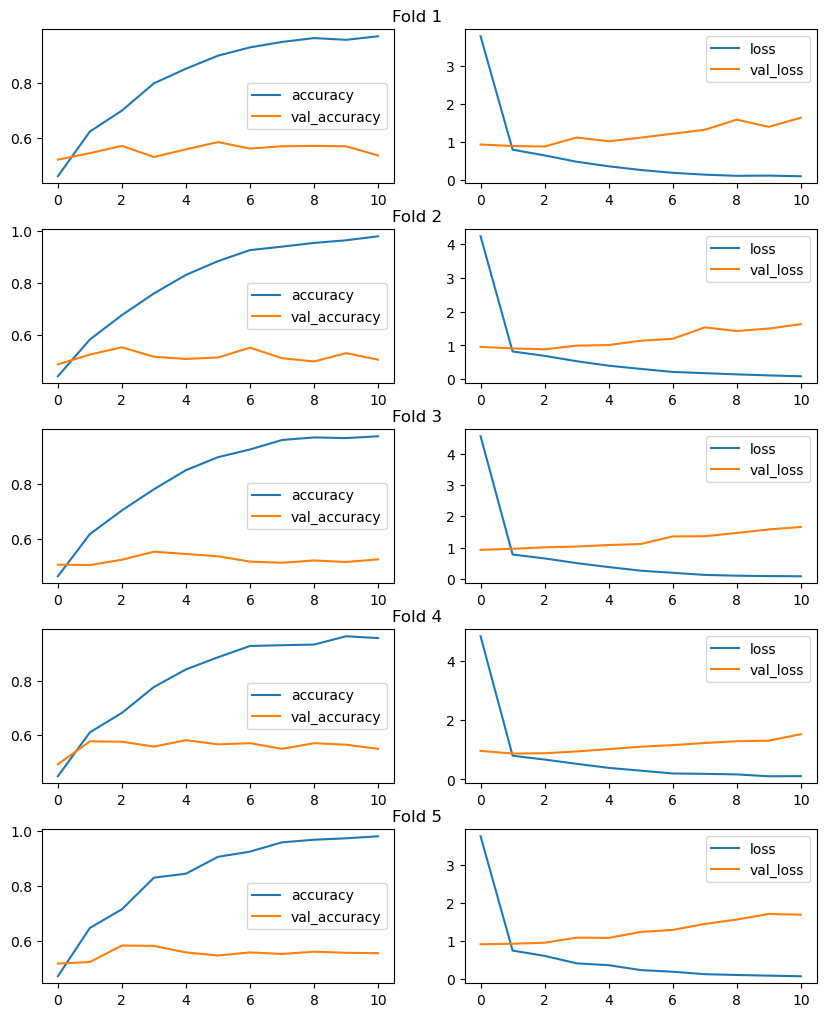

In [39]:
plot_history(histories)

In [40]:
print(report)

              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1116
           1       0.51      0.50      0.51      1479
           2       0.58      0.59      0.59       991

    accuracy                           0.55      3586
   macro avg       0.55      0.56      0.56      3586
weighted avg       0.55      0.55      0.55      3586



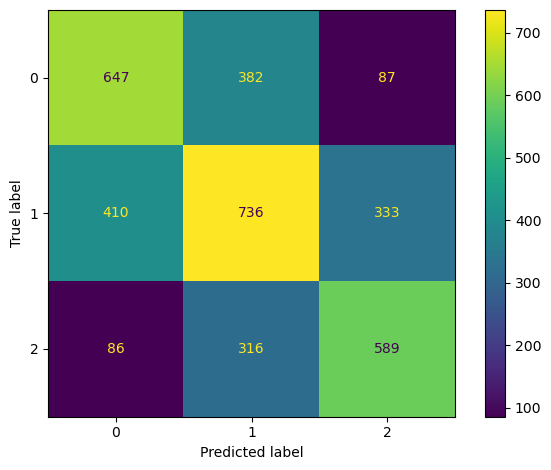

In [41]:
disp.plot()
plt.tight_layout()

## block12_sepconv2_act

In [42]:
# torch.cuda.empty_cache()

In [43]:
histories, report, disp = extract_train_predict_cv('block12_sepconv2_act')

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Shape of features: (3586, 8, 8, 728)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4280 - loss: 9.4887 - val_accuracy: 0.5306 - val_loss: 0.9294
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5837 - loss: 0.8435 - val_accuracy: 0.5682 - val_loss: 0.8843
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6345 - loss: 0.7454 - val_accuracy: 0.5641 - val_loss: 0.8898
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6792 - loss: 0.6802 - val_accuracy: 0.5724 - val_loss: 0.8813
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6818 - loss: 0.6735 - val_accuracy: 0.5877 - val_loss: 0.8715
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7107 - loss: 0.6192 - val_accuracy: 0.5627 - val_loss: 0.9275
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7359 - loss: 0.5498 - val_ac

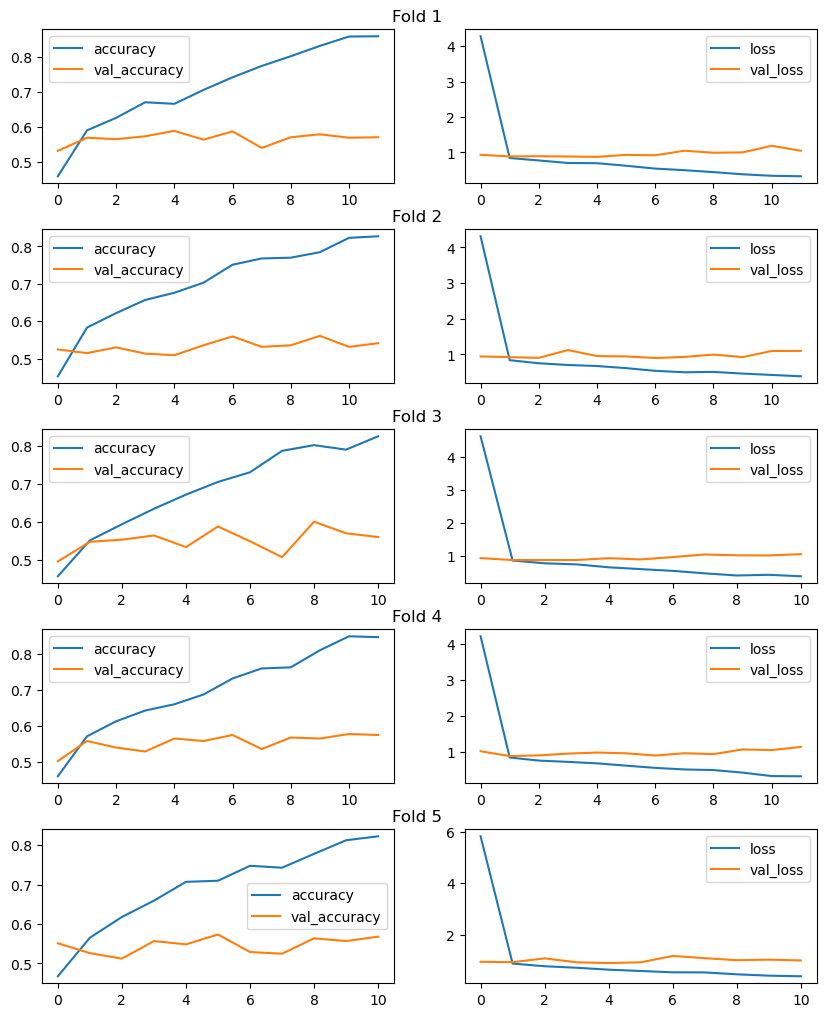

In [44]:
plot_history(histories)

In [45]:
print(report)

              precision    recall  f1-score   support

           0       0.64      0.52      0.57      1116
           1       0.51      0.61      0.56      1479
           2       0.64      0.59      0.62       991

    accuracy                           0.58      3586
   macro avg       0.60      0.57      0.58      3586
weighted avg       0.59      0.58      0.58      3586



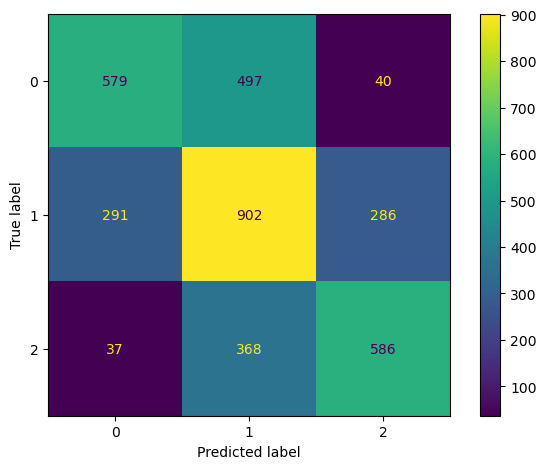

In [46]:
disp.plot()
plt.tight_layout()

## block13_sepconv2_bn

This layer had an interesting correlated heatmap

In [25]:
histories, report, disp = extract_train_predict_cv('block13_sepconv2_bn')

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
Shape of features: (3586, 8, 8, 1024)
Training on fold 1...
Class weights: [1.07174888 0.80743243 1.20707071]
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.4319 - loss: 63.1554 - val_accuracy: 0.4819 - val_loss: 1.2431
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5283 - loss: 1.0082 - val_accuracy: 0.5084 - val_loss: 0.9177
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5535 - loss: 0.8567 - val_accuracy: 0.5641 - val_loss: 0.8898
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5901 - loss: 0.8015 - val_accuracy: 0.5056 - val_loss: 0.9268
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5688 - loss: 0.8084 - val_accuracy: 0.5265 - val_loss: 0.9347
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6175 - loss: 0.7436 - val_accuracy: 0.5209 - val_loss: 0.9105
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6137 - loss: 0.7783 - va

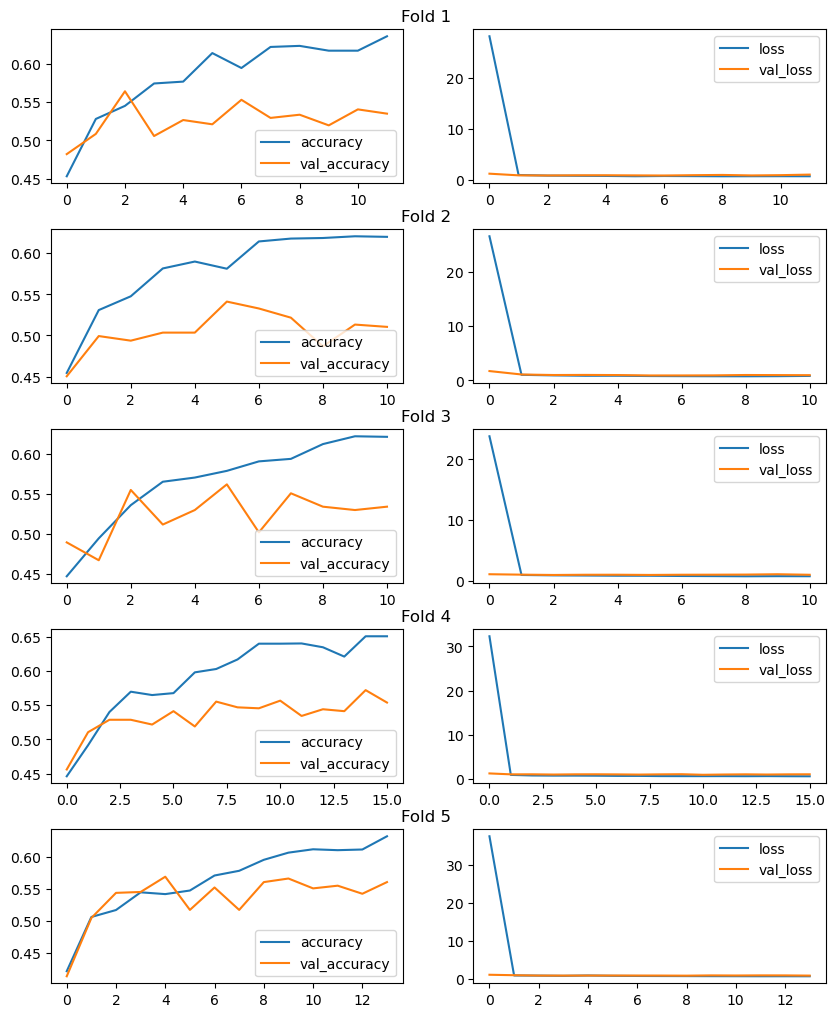

In [26]:
plot_history(histories)

In [27]:
print(report)

              precision    recall  f1-score   support

           0       0.56      0.62      0.59      1116
           1       0.51      0.46      0.49      1479
           2       0.60      0.62      0.61       991

    accuracy                           0.55      3586
   macro avg       0.56      0.57      0.56      3586
weighted avg       0.55      0.55      0.55      3586



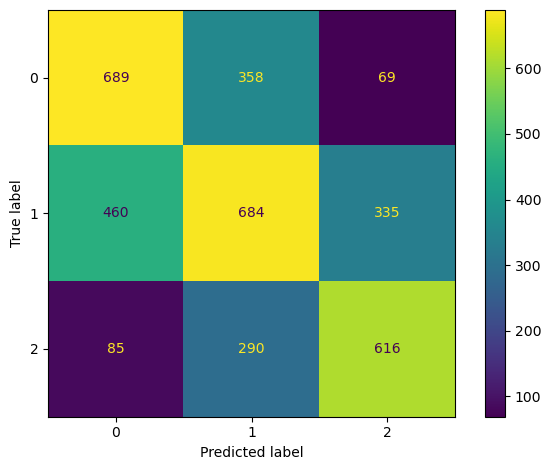

In [28]:
disp.plot()
plt.tight_layout()